In [65]:
import csv, sys, os, re
from collections import Counter
import numpy
from matplotlib import pyplot
from sklearn.cluster import KMeans, AgglomerativeClustering
from collections import defaultdict
from matplotlib.pyplot import *
import matplotlib.pyplot as plt


word_pattern = re.compile("\w[\w\-\']*\w|\w")

In [45]:
documents = []

with open("./data/metadata.csv", encoding="utf-8") as reader:
    csv_reader = csv.DictReader(reader)
    for document in csv_reader:
        try:
            with open("./data/{}".format(document["Filename"]), encoding="utf-8") as reader:
                print(document["Author"] + " / " + document["Title"])

                lines = []
                for line in reader:
                    lines.append(line.rstrip())

                text = " ".join(lines)
                document["Text"] = text
                document["Tokens"] = word_pattern.findall(text)
                document["Horror"] = "Horror" in document["Genre"] or "horror" in document["Genre"]
                
                documents.append(document)
        except Exception as e:
            print("! Problem with {}: {}".format(document["Filename"], e))

Austen, Jane / Emma
Austen, Jane / Persuasion
Austen, Jane / Pride and Prejudice
Austen, Jane / Sense and Sensibility
! Problem with baring_gould_the_book_of_werewolves_pg5324.txt: [Errno 2] No such file or directory: './data/baring_gould_the_book_of_werewolves_pg5324.txt'
Baum, Lyman Frank / Glinda of Oz
Baum, Lyman Frank / The Wonderful Wizard of Oz
Beckford, William / Vathek
! Problem with beckford_vathek_an_arabian_tale_pg42401.txt: 'utf-8' codec can't decode byte 0xd2 in position 1716: invalid continuation byte
Bierce, Ambrose / An Occurrence at Owl Creek Bridge
Bierce, Ambrose / Present at a Hanging and Other Ghost Stories
Bierce, Ambrose / The Parenticide Club
Bierce, Ambrose / The Damned Thing
Birkhead, Edith / The Tale of Terror
! Problem with edith_the_tale_of_terror_pg14154.txt: 'utf-8' codec can't decode byte 0xe9 in position 6657: invalid continuation byte
Blackwood, Algernon / The Damned
Blackwood, Algernon / The Willows
Blackwood, Algernon / Four Weird Tales
Blackwood, A

In [46]:
all_counts = Counter()

for document in documents:
    doc_counter = Counter(document["Tokens"])
    all_counts += doc_counter   
    document["TokenCounts"] = doc_counter

In [58]:
Counter([doc["Horror"] for doc in documents])
print(documents[0]["TokenCounts"])

Counter({'to': 5099, 'the': 4819, 'and': 4408, 'of': 4264, 'I': 3073, 'a': 2960, 'was': 2373, 'her': 2328, 'in': 2088, 'not': 2081, 'it': 2070, 'be': 1964, 'she': 1752, 'that': 1689, 'you': 1664, 'had': 1600, 'as': 1383, 'he': 1347, 'have': 1300, 'for': 1288, 'is': 1213, 'with': 1183, 'Mr': 1141, 'very': 1139, 'his': 1083, 'but': 1009, 'at': 989, 'so': 899, 'could': 822, 'all': 821, 'would': 810, 'Emma': 776, 'been': 757, 'him': 742, 'Mrs': 690, 'on': 674, 'any': 649, 'my': 616, 'no': 592, 'were': 588, 'Miss': 587, 'do': 568, 'She': 562, 'must': 561, 'by': 554, 'me': 549, 'will': 542, 'which': 535, 'from': 532, 'said': 481, 'much': 470, 'or': 469, 'more': 459, 'an': 450, 'are': 446, 'He': 441, 'such': 432, 'them': 423, 'what': 418, 'than': 416, 'this': 415, 'Harriet': 412, 'am': 410, 'there': 409, 'It': 396, 'every': 393, 'thing': 392, 'they': 387, 'one': 387, 'Weston': 384, 'think': 379, 'should': 365, 'if': 362, 'being': 356, 'The': 356, 'little': 354, 'Knightley': 353, 'never': 339,

In [48]:
def load_word_weights(lexicon_file):

    ## Create a mapping from words to numbers
    ## {word: emotion: 0/1}
    
    # This creates a depth two dictionary where the default value is 0.
    word_weights = defaultdict(lambda: defaultdict(int))
    with open(lexicon_file, 'r') as lexicon_reader:
        for line in lexicon_reader:
            word, emotion, weight = [e.strip() for e in line.split("\t")] ## split on comma
            word_weights[word][emotion] = int(weight)
    
    return word_weights

word_weights = load_word_weights("lexicon.txt")


In [50]:
emotions = ['anger',
'anticipation',
'disgust',
'fear',
'joy',
'negative',
'positive',
'sadness',
'surprise',
'trust']

def emotion_score(doc):
    res = {}
    
    token_count = doc["TokenCounts"]
    for emotion in emotions:
        # negative
        emotion_count = 0
        total_token_count = 0
        for token, count in token_count.items():
            emotion_count += word_weights[token][emotion] * count
            total_token_count += count
        ratio = emotion_count/total_token_count
        res[emotion] = ratio
    return res

print(emotion_score(documents[0]))
print(documents[0]["Horror"])


{'anger': 0.009209839755074842, 'anticipation': 0.028339902809472618, 'disgust': 0.007336438903871904, 'fear': 0.013899628463119778, 'joy': 0.026271617977104277, 'negative': 0.02627790455714187, 'positive': 0.055045294809170864, 'sadness': 0.013428134960300247, 'surprise': 0.013069799898157403, 'trust': 0.03139518070774318}
False


Counter({'anger': 0.009209839755074842,
         'anticipation': 0.028339902809472618,
         'disgust': 0.007336438903871904,
         'fear': 0.013899628463119778,
         'joy': 0.026271617977104277,
         'negative': 0.02627790455714187,
         'positive': 0.055045294809170864,
         'sadness': 0.013428134960300247,
         'surprise': 0.013069799898157403,
         'trust': 0.03139518070774318})

In [84]:
horror_ratios = Counter()
non_horror_ratios = Counter()
num_horrors = len([1 for doc in documents if doc["Horror"]])
num_non_horrors = len([1 for doc in documents if not doc["Horror"]])

for doc in documents:
    if doc["Horror"]:
        horror_ratios += Counter(emotion_score(doc))
    else:
        non_horror_ratios += Counter(emotion_score(doc))

for k, v in horror_ratios.items():
    horror_ratios[k] = v/num_horrors

for k, v in non_horror_ratios.items():
    non_horror_ratios[k] = v/num_non_horrors

print(horror_ratios)
print(non_horror_ratios)


Counter({'positive': 0.040035328014289176, 'negative': 0.036997039757539894, 'trust': 0.02296053881300004, 'fear': 0.021271033429422694, 'anticipation': 0.020903003168372816, 'sadness': 0.018973146032578676, 'joy': 0.016454448487288893, 'anger': 0.014765332077139141, 'surprise': 0.011497713491444567, 'disgust': 0.011040075849638188})
Counter({'positive': 0.0408506564216608, 'negative': 0.03169358360764369, 'trust': 0.024558743429392495, 'anticipation': 0.021212063732677346, 'fear': 0.017651681357200896, 'joy': 0.017548977356903524, 'sadness': 0.01618365275868437, 'anger': 0.013022518812757747, 'surprise': 0.011114576776034241, 'disgust': 0.00893191232292915})


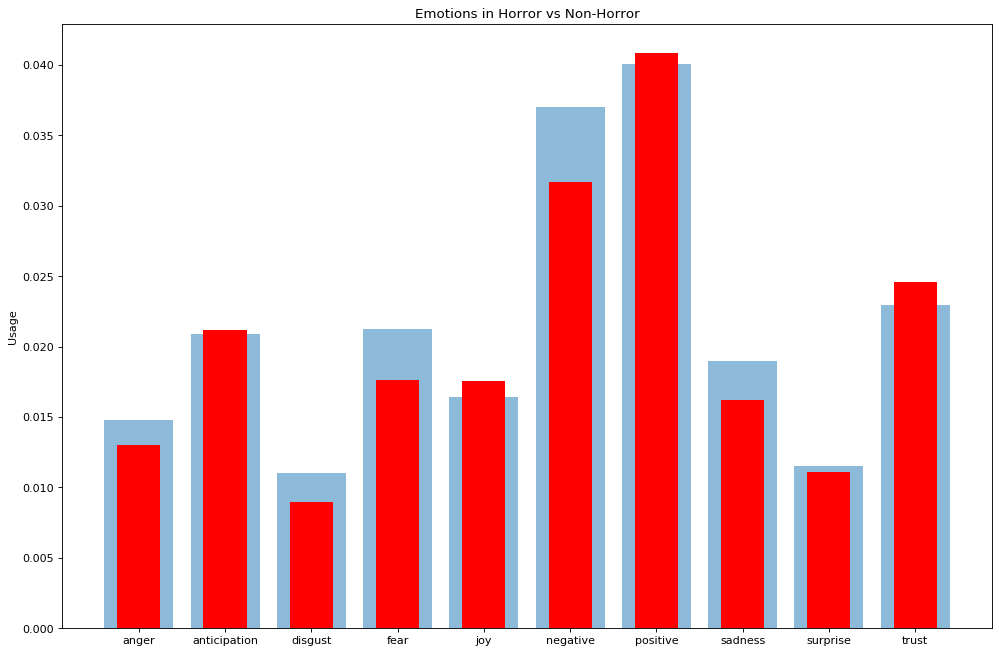

In [90]:
emotions = [k for k, v in horror_ratios.items()]
ratios = [v for k, v in horror_ratios.items()]

non_horror_ratio_vals = [v for k, v in non_horror_ratios.items()]

y_pos = numpy.arange(len(emotions))

figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')


plt.bar(y_pos, ratios, align='center', alpha=0.5)
plt.bar(y_pos, non_horror_ratio_vals, width=.5, color='r', align='center')
plt.xticks(y_pos, emotions)
plt.ylabel('Usage')
plt.title('Emotions in Horror vs Non-Horror')


plt.show()
